In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('./labeledTrainData.tsv', delimiter='\t')
df

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...
...,...,...,...
24995,3453_3,0,It seems like more consideration has gone into...
24996,5064_1,0,I don't believe they made this film. Completel...
24997,10905_3,0,"Guy is a loser. Can't get girls, needs to buil..."
24998,10194_3,0,This 30 minute documentary Buñuel made in the ...


In [6]:
df.isna().sum()

id           0
sentiment    0
review       0
dtype: int64

<BarContainer object of 2 artists>

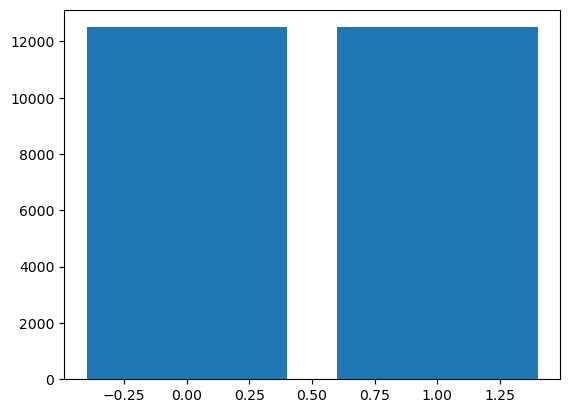

In [11]:
instance_values = df['sentiment'].value_counts()
plt.bar(instance_values.index, instance_values.values)

In [12]:
import nltk
from nltk.corpus import stopwords

In [13]:
stop_words = set(stopwords.words('english'))  # Postavite jezik na engleski

# Funkcija za uklanjanje stop riječi iz teksta
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Primjena funkcije na stupac 'text' u DataFrame-u
df['review'] = df['review'].apply(remove_stopwords)
df['review']

In [15]:
df.drop('id', axis= 1, inplace= True)

In [18]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import string

# Funkcija za obradu teksta
def process_text(text):
    # Tokenizacija
    tokens = word_tokenize(text)
    # Uklanjanje interpunkcije
    tokens = [word for word in tokens if word.isalnum()]
    # Lowercasing
    tokens = [word.lower() for word in tokens]
    return tokens

# Primena funkcije na kolonu 'review'
df['processed_review'] = df['review'].apply(process_text)

# Kreiranje Word2Vec modela
model = Word2Vec(df['processed_review'], vector_size=100, window=5, min_count=1, workers=4)

# Testiranje
vector = model.wv['word']  # Vektor za reč 'word'


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Podela podataka na trening i test skup
X_train, X_test, y_train, y_test = train_test_split(df['processed_review'], df['sentiment'], test_size=0.2, random_state=42)

# Pretvaranje Word2Vec vektora u prosečne vektore rečenica
def get_sentence_vectors(sentences, model):
    vectors = []
    for sentence in sentences:
        sentence_vector = [model.wv[word] for word in sentence if word in model.wv]
        if sentence_vector:
            vectors.append(sum(sentence_vector) / len(sentence_vector))
        else:
            vectors.append([0] * model.vector_size)  # If all words are out-of-vocabulary
    return vectors

X_train_vectors = get_sentence_vectors(X_train, model)
X_test_vectors = get_sentence_vectors(X_test, model)

# Kreiranje SVM modela
svm_model = SVC(kernel='linear')

# Obuka SVM modela
svm_model.fit(X_train_vectors, y_train)

# Predikcija na test skupu
y_pred = svm_model.predict(X_test_vectors)

# Evaluacija modela
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.83      0.84      2481
           1       0.84      0.86      0.85      2519

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000

